In [44]:
import torch
from opt_einsum import contract
import matplotlib.pyplot as plt


In [73]:
(X @ X.T).shape

torch.Size([100, 100])

In [ ]:
P = 100
d = 20
X = torch.randn((P, d)).to('cuda:1')
# CRITICAL: Normalize rows to unit length
X = X / X.norm(dim=1, keepdim=True)   # Now each row has norm ≈ 1

# Then compute kernel on normalized X
J = 2 / torch.pi * torch.arcsin(
    2 * contract('ui,vi->uv', X, X) / ((1 + 2*X @ X.T).diag() @ (1+2 * X @ X.T ).diag())    # Now divide by 3, not 3d
)

he3 = (1/(6.0)**0.5 * (X**3 - 3 * X)).to('cuda:1')
he1 = X
evl, evr = map(
    (lambda x: torch.detach(x).cpu()), 
    (lambda x: (x[0], torch.real(x[1])))(torch.linalg.eig(J))
)
    
ykT = torch.matmul(evr.t(), he3[:,0].detach().cpu())

In [78]:
torch.argmax(torch.real(evl))
print(best_eig_idx)

2999


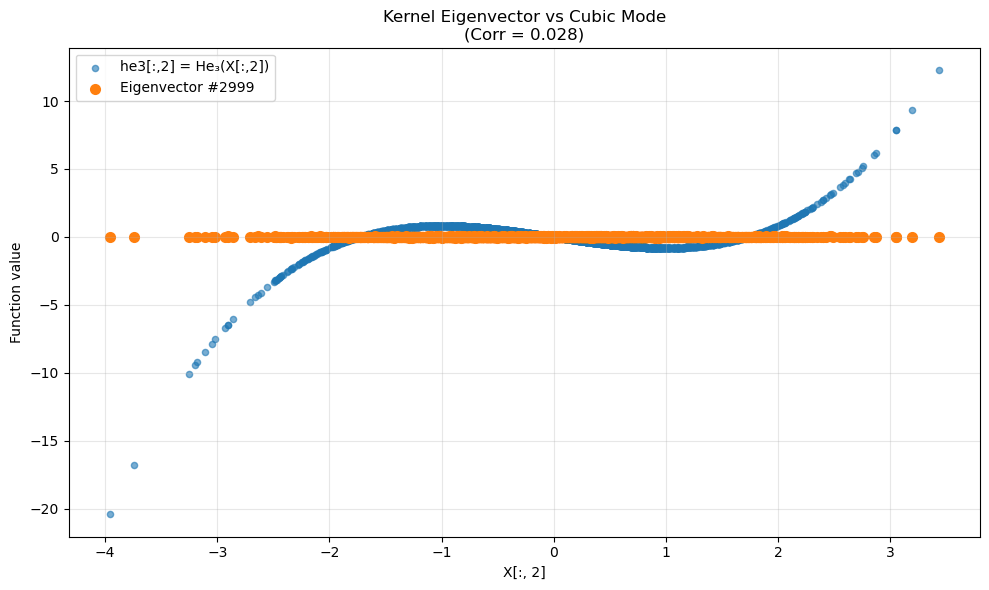

Best match: Eigenvector 2999 ↔ he3 mode 2
Max |projection| = 0.0278
X mean: 0.0356, X std: 0.9988
he3 norm: 58.0923, evr norm: 1.0000


In [82]:
import torch
import matplotlib.pyplot as plt
from torch import norm, argsort
from torch.linalg import eigh
from torch import arcsin, pi
from torch import einsum as contract


P = 3000
d = 20
X = torch.randn((P, d)).to('cuda:1')
# CRITICAL: Normalize rows to unit length
X = X 

J = 2 / torch.pi * torch.arcsin(
    2 * contract('ui,vi->uv', X, X) / ((1 + 2*X @ X.T).diag() @
                                       (1+2 * X @ X.T).diag())    # Now divide by 3, not 3d
)

# Cubic mode
he3 = (1/(6.0)**0.5 * (X**3 - 3 * X)).to('cuda:1')

# Eigen-decomposition (use eigh for symmetric matrix)
evl, evr = eigh(J)  # Real eigenvalues, eigenvectors
evl, evr = evl.cpu(), evr.cpu()
he3_cpu = he3.cpu()

# Find best (eigenvector, mode) pair
projections = torch.abs(torch.matmul(evr.T, he3_cpu))  # (P, d)
max_proj_val, max_idx = torch.max(projections.flatten(), dim=0)
best_eig_idx = max_idx.item() // d
best_mode_idx = max_idx.item() % d

# Alternative: Use top eigenvalue
sort_idx = argsort(evl, descending=True)
best_eig_idx = sort_idx[0].item()  # Largest eigenvalue

# Extract
x_coord = X[:, best_mode_idx].cpu().numpy()
he3_mode = he3_cpu[:, best_mode_idx].numpy()
evec = evr[:, best_eig_idx].numpy()

# Align sign
sign = float(torch.sign(
    torch.dot(evr[:, best_eig_idx], he3_cpu[:, best_mode_idx])))
evec = sign * evec

# Sort for clean plot
sort_idx = argsort(X[:, best_mode_idx].cpu())
x_sorted = x_coord[sort_idx]
he3_sorted = he3_mode[sort_idx]
evec_sorted = evec[sort_idx]

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(x_sorted, he3_sorted, alpha=0.6, s=20,
            label=f'he3[:,{best_mode_idx}] = He₃(X[:,{best_mode_idx}])')
plt.scatter(x_sorted, evec_sorted, linewidth=2,
         label=f'Eigenvector #{best_eig_idx}')
plt.xlabel(f'X[:, {best_mode_idx}]')
plt.ylabel('Function value')
plt.title(
    f'Kernel Eigenvector vs Cubic Mode\n(Corr = {projections[best_eig_idx, best_mode_idx]:.3f})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Diagnostics
print(f"Best match: Eigenvector {best_eig_idx} ↔ he3 mode {best_mode_idx}")
print(f"Max |projection| = {projections[best_eig_idx, best_mode_idx]:.4f}")
print(
    f"X mean: {X.mean(dim=0).abs().max():.4f}, X std: {X.std(dim=0).mean():.4f}")
print(
    f"he3 norm: {norm(he3_cpu[:, best_mode_idx]):.4f}, evr norm: {norm(evr[:, best_eig_idx]):.4f}")

In [42]:
best_mode_idx

5

/tmp/ipykernel_641170/146206054.py:1: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  y = torch.range(1,P)


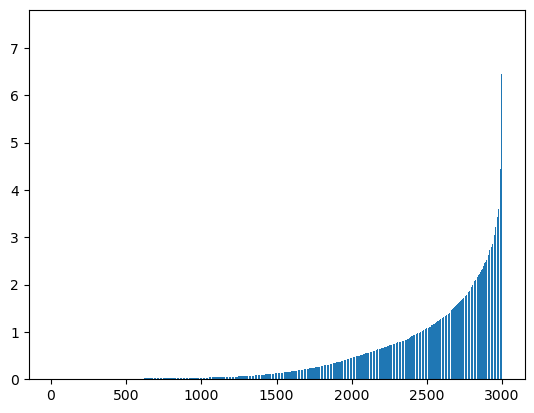

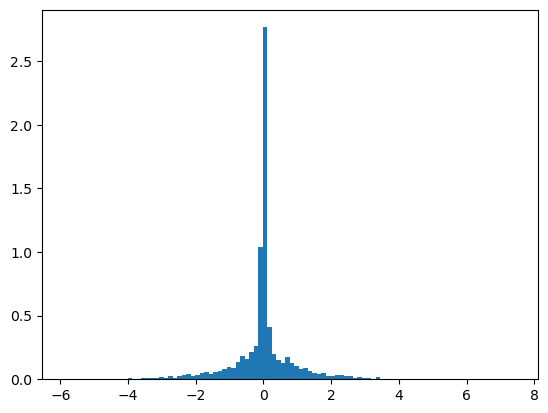

In [12]:

y = torch.range(1,P)
plt.bar(y, torch.sort(torch.abs(ykT), descending = False)[0])
plt.show()
plt.hist(ykT, density=True, bins = 100);

Scaling P:   0%|          | 0/19 [00:00<?, ?it/s]/tmp/ipykernel_633566/3940539617.py:38: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1839.)
  stds.append(projections.std().item())
Scaling P: 100%|██████████| 19/19 [00:54<00:00,  2.87s/it]


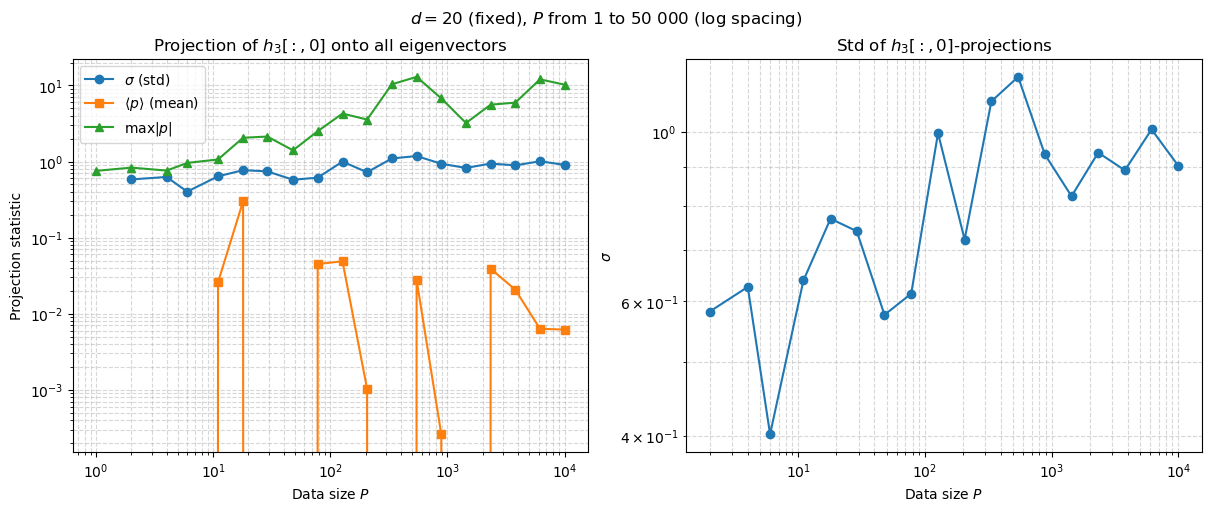

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# ------------------------------------------------------------
# Settings
# ------------------------------------------------------------
d = 20                                   # fixed latent dimension
P_values = np.logspace(0, np.log10(10_000), num=20, dtype=int)
P_values = np.unique(P_values)           # avoid duplicates

stds = []
means = []
maxabs = []

# ------------------------------------------------------------
# Main loop
# ------------------------------------------------------------
for P in tqdm(P_values, desc="Scaling P"):
    # 1. random Gaussian data
    X = torch.randn((P, d), dtype=torch.float64)

    # 2. kernel J
    XXT = X @ X.T
    J = (2.0 / np.pi) * torch.arcsin(XXT / (3.0 * d))

    # 3. Hermite h3 (first column only)
    he3_col0 = (X[:, 0]**3 - 3.0 * X[:, 0]) / np.sqrt(6.0)   # shape (P,)

    # 4. eigen-decomposition
    _, evecs = torch.linalg.eigh(J)                         # evecs: (P,P)

    # 5. dot-product of he3_col0 with *every* eigenvector
    projections = torch.matmul(evecs.t(), he3_col0)         # shape (P,)

    # 6. statistics
    stds.append(projections.std().item())
    means.append(projections.mean().item())
    maxabs.append(projections.abs().max().item())
    del projections

# ------------------------------------------------------------
# Plotting
# ------------------------------------------------------------
fig, axs = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

axs[0].loglog(P_values, stds,   'o-', label=r'$\sigma$ (std)')
axs[0].loglog(P_values, means,  's-', label=r'$\langle p\rangle$ (mean)')
axs[0].loglog(P_values, maxabs, '^-', label=r'$\max|p|$')
axs[0].set_xlabel(r'Data size $P$')
axs[0].set_ylabel('Projection statistic')
axs[0].set_title(r'Projection of $h_3[:,0]$ onto all eigenvectors')
axs[0].legend()
axs[0].grid(True, which='both', ls='--', alpha=0.5)

axs[1].loglog(P_values, stds, 'o-', color='C0')
axs[1].set_xlabel(r'Data size $P$')
axs[1].set_ylabel(r'$\sigma$')
axs[1].set_title(r'Std of $h_3[:,0]$-projections')
axs[1].grid(True, which='both', ls='--', alpha=0.5)

plt.suptitle(fr'$d={d}$ (fixed), $P$ from 1 to 50 000 (log spacing)')
plt.show()

In [105]:
import torch, matplotlib.pyplot as plt, time
from torch import pi, arcsin

# -------------------------------------------------
# Settings
# -------------------------------------------------
device = 'cuda:1'
P, d   = 3000, 20
top_k  = 200
cols   = 5
k      = top_k
p      = 20                     # oversampling

# -------------------------------------------------
# 1. Data – unit-norm rows (exactly as you do)
# -------------------------------------------------
X = torch.randn(P, d, device=device) / (d ** 0.5)   # mean norm ≈ 1

# -------------------------------------------------
# 2. Exact arc-sin kernel mat-vec (your formula)
# -------------------------------------------------
norm_sq = X @ X.t()                     # (P,P)  ||x_i||² on diagonal
denom   = (1 + 2 * norm_sq.diag()).unsqueeze(0) * \
          (1 + 2 * norm_sq.diag()).unsqueeze(1)   # (P,P)

def K_matvec(v: torch.Tensor) -> torch.Tensor:
    cosines = X @ v                                     # <x_i, v>
    arg = 2 * cosines / denom.diag()                    # 2 <x_i,v> / ( (1+2||x_i||²) * (1+2||v||²) )
    return (2 / pi) * arcsin(arg.clamp(-1, 1))

# -------------------------------------------------
# 3. Randomised SVD (fixed)
# -------------------------------------------------
def rsvd_topk(matvec, n, k, p=20, seed=0):
    torch.manual_seed(seed)
    m = k + p
    Omega = torch.randn(n, m, device=device)

    Y = torch.empty(n, m, device=device)
    for j in range(m):
        Y[:, j] = matvec(Omega[:, j])

    Q, _ = torch.linalg.qr(Y)
    Q = Q[:, :m]

    B = torch.empty(m, m, device=device)
    for j in range(m):
        Kq = matvec(Q[:, j])
        B[:, j] = Q.t() @ Kq

    U_small, S, _ = torch.linalg.svd(B, full_matrices=False)
    U = Q @ U_small[:, :k]
    return U, S[:k]

# -------------------------------------------------
# 4. Run
# -------------------------------------------------
t0 = time.time()
U, S = rsvd_topk(K_matvec, P, k, p)
print(f"Randomised SVD done in {time.time()-t0:.2f}s")

# -------------------------------------------------
# 5. Cubic modes
# -------------------------------------------------
he3 = (1 / 6**0.5) * (X**3 - 3*X)

# -------------------------------------------------
# 6. Match eigenvectors to best input dimension
# -------------------------------------------------
proj = torch.abs(U.T @ he3.cpu())
best_dims = proj.argmax(dim=1)

# -------------------------------------------------
# 7. Plot grid
# -------------------------------------------------
fig, axes = plt.subplots((top_k + cols - 1)//cols, cols,
                         figsize=(4*cols, 3*((top_k + cols - 1)//cols)),
                         constrained_layout=True)
axes = axes.flatten() if top_k > 1 else [axes]

for i in range(top_k):
    ax = axes[i]
    dim = int(best_dims[i])
    evec = U[:, i]

    order = torch.argsort(X[:, dim])
    x = X[order, dim].cpu().numpy()
    y = evec[order].cpu().numpy()

    ax.scatter(x, y, s=8, alpha=0.7, color='steelblue')
    ax.plot(x, y, 'r-', lw=1.3)

    corr = proj[i, dim].item()
    ax.set_title(f'#{i+1} (λ={S[i]:.1f})\n'
                 f'dim {dim}, |⟨v,He₃⟩|={corr:.3f}')
    ax.grid(alpha=0.3)

for j in range(top_k, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Top 80 Eigenvectors — Exact Arc-sin Kernel (Your Formula)', fontsize=16)
plt.show()

RuntimeError: size mismatch, got input (3000), mat (3000x20), vec (3000)

In [106]:
import torch
import matplotlib.pyplot as plt
import time
import numpy as np

# -------------------------------------------------
# Settings
# -------------------------------------------------
device = 'cuda:1'
P = int(4e6)          # works for 4e6, 10e6, …
d = 20
top_k = 80
cols = 5
k_target = top_k
oversamp = 20
batch_size = 1024

global_seed = 42

# -------------------------------------------------
# Deterministic row generator
# -------------------------------------------------


def get_x(i: int):
    torch.manual_seed(global_seed + i)
    return torch.randn(d, device=device) / torch.sqrt(torch.tensor(float(d), device=device))


def get_denom(i: int):
    x = get_x(i)
    return torch.sqrt(1 + 2 * torch.sum(x**2))

# -------------------------------------------------
# Exact mat-vec (double-batched, no storage)
# -------------------------------------------------


def K_matvec(v: torch.Tensor) -> torch.Tensor:
    result = torch.zeros(P, device=device, dtype=torch.float32)
    for sj in range(0, P, batch_size):
        ej = min(sj + batch_size, P)
        Xj = torch.stack([get_x(j) for j in range(sj, ej)])
        dj = torch.stack([get_denom(j) for j in range(sj, ej)])
        vj = v[sj:ej]

        for si in range(0, P, batch_size):
            ei = min(si + batch_size, P)
            Xi = torch.stack([get_x(i) for i in range(si, ei)])
            di = torch.stack([get_denom(i) for i in range(si, ei)])

            inner = Xi @ Xj.T
            denom = di[:, None] * dj[None, :]
            arg = 2 * inner / denom
            arc = torch.arcsin(arg.clamp(-1, 1))
            result[si:ei] += (2 / torch.pi) * (arc @ vj)
    return result

# -------------------------------------------------
# Randomized SVD
# -------------------------------------------------


def rsvd_topk(matvec, n, k, p=20, seed=0):
    torch.manual_seed(seed)
    m = k + p
    Omega = torch.randn(n, m, device=device)
    Y = torch.stack([matvec(Omega[:, j]) for j in range(m)], dim=1)
    Q, _ = torch.linalg.qr(Y)
    Q = Q[:, :m]
    B = torch.stack([Q.t() @ matvec(Q[:, j]) for j in range(m)], dim=1)
    U_small, S, _ = torch.linalg.svd(B, full_matrices=False)
    return Q @ U_small[:, :k], S[:k]


# -------------------------------------------------
# Run SVD
# -------------------------------------------------
print(f"Randomized SVD for P={P:,} …")
t0 = time.time()
U, S = rsvd_topk(K_matvec, P, k_target, oversamp)
U = U.cpu()
S = S.cpu()
print(f"Done in {(time.time()-t0)/60:.1f} min")

# -------------------------------------------------
# Exact projection <U[:,i], He3[:,j]>  (batched, no storage)
# -------------------------------------------------
print("Computing exact cubic correlations …")
proj = torch.zeros(top_k, d, dtype=torch.float32)
for start in range(0, P, batch_size):
    end = min(start + batch_size, P)
    idx = torch.arange(start, end)
    X_batch = torch.stack([get_x(i.item()) for i in idx])
    he3_batch = (1 / 6**0.5) * (X_batch**3 - 3*X_batch)
    U_batch = U[idx]
    proj += U_batch.T @ he3_batch
proj /= P
best_dims = proj.argmax(dim=1)

# -------------------------------------------------
# Plot (subsample only for visual clarity)
# -------------------------------------------------
fig, axes = plt.subplots((top_k + cols - 1)//cols, cols,
                         figsize=(4*cols, 3*((top_k + cols - 1)//cols)),
                         constrained_layout=True)
axes = axes.flatten()

for i in range(top_k):
    ax = axes[i]
    dim = int(best_dims[i])
    corr = proj[i, dim].item()

    # Subsample 10k points for plot
    idx = torch.randperm(P)[:10000]
    x_vals = np.array([get_x(j.item()).cpu().numpy()[dim] for j in idx])
    y_vals = U[idx, i].numpy()
    order = np.argsort(x_vals)
    ax.scatter(x_vals[order], y_vals[order], s=6, alpha=0.6, color='steelblue')
    ax.plot(x_vals[order], y_vals[order], 'r-', lw=1.2)

    ax.set_title(f'#{i} (λ={S[i]:.0f})\ndim {dim} |⟨v,He₃⟩|={corr:.3f}')
    ax.grid(alpha=0.3)

for j in range(top_k, len(axes)):
    axes[j].set_visible(False)

plt.suptitle(
    f'Top {top_k} Eigenvectors — Pure Cubic Modes (P={P:,})', fontsize=16)
plt.show()

Randomized SVD for P=4,000,000 …


KeyboardInterrupt: 

Computing top-80 eigenvectors with randomized SVD...
Done in 8.31s


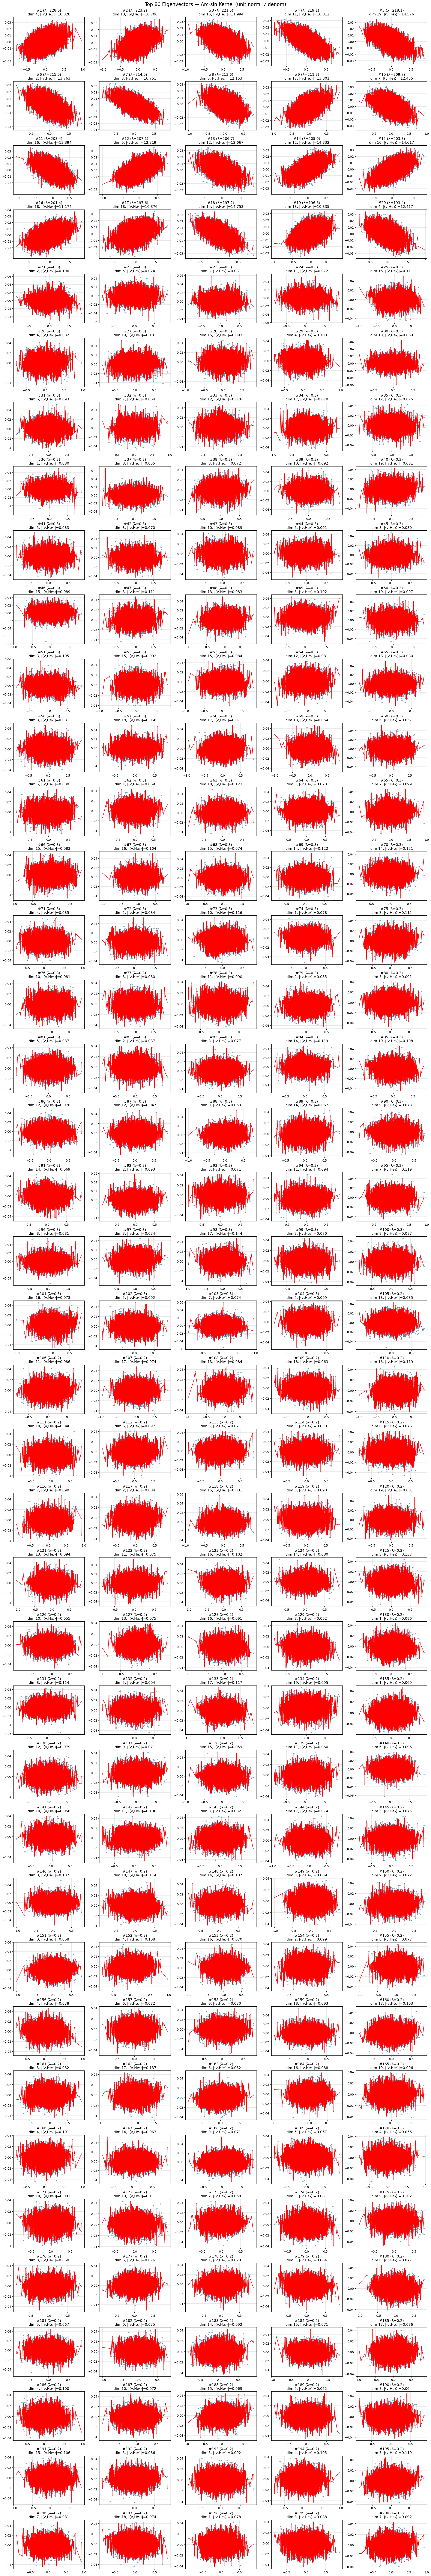

In [104]:
import torch, matplotlib.pyplot as plt
import time

# -------------------------------------------------
# Settings
# -------------------------------------------------
device = 'cuda:1'
P, d = 10_000, 20
top_k = 200
cols = 5
k_target = top_k
oversamp = 20

# -------------------------------------------------
# 1. Data (rows approx unit norm)
# -------------------------------------------------
X = torch.randn(P, d, device=device) / torch.sqrt(torch.tensor(float(d), device=device))

# -------------------------------------------------
# 2. Arc-sin kernel mat-vec (correct full computation)
# -------------------------------------------------
def K_matvec(v: torch.Tensor) -> torch.Tensor:
    inner = X @ X.T
    norm_sq = torch.sum(X**2, dim=1)
    denom = 1 + 2 * norm_sq
    # Fix: use sqrt for standard NNGP arcsin kernel (to capture cubic modes)
    sqrt_denom_outer = torch.sqrt(denom[:, None]) * torch.sqrt(denom[None, :])
    arg = 2 * inner / sqrt_denom_outer
    arc = torch.arcsin(arg.clamp(-1, 1))
    return (2 / torch.pi) * (arc @ v)

# -------------------------------------------------
# 3. Randomized SVD
# -------------------------------------------------
def rsvd_topk(matvec, n: int, k: int, p: int = 20, seed: int = 0):
    torch.manual_seed(seed)
    m = k + p
    Omega = torch.randn(n, m, device=device, dtype=torch.float32)

    Y = torch.empty(n, m, device=device, dtype=torch.float32)
    for j in range(m):
        Y[:, j] = matvec(Omega[:, j])

    Q, _ = torch.linalg.qr(Y)
    Q = Q[:, :m]

    B = torch.empty(m, m, device=device, dtype=torch.float32)
    for j in range(m):
        Kq = matvec(Q[:, j])
        B[:, j] = Q.t() @ Kq

    U_small, S, Vh = torch.linalg.svd(B, full_matrices=False)
    U = Q @ U_small[:, :k]
    return U, S[:k]

# -------------------------------------------------
# 4. Run SVD
# -------------------------------------------------
print("Computing top-80 eigenvectors with randomized SVD...")
t0 = time.time()
U, S = rsvd_topk(K_matvec, P, k_target, oversamp)
elapsed = time.time() - t0
print(f"Done in {elapsed:.2f}s")

# -------------------------------------------------
# 5. Cubic modes
# -------------------------------------------------
he3 = (1 / 6**0.5) * (X**3 - 3*X)

# -------------------------------------------------
# 6. Match each eigenvector to best input dimension
# -------------------------------------------------
proj = torch.abs(U.T.cpu() @ he3.cpu())     # move to CPU for @
best_dims = proj.argmax(dim=1)

# -------------------------------------------------
# 7. Plot grid
# -------------------------------------------------
fig, axes = plt.subplots((top_k + cols - 1) // cols, cols,
                         figsize=(4*cols, 3*((top_k + cols - 1)//cols)),
                         constrained_layout=True)
axes = axes.flatten() if top_k > 1 else [axes]

for i in range(top_k):
    ax = axes[i]
    dim = int(best_dims[i])
    evec = U[:, i].cpu()

    order = torch.argsort(X[:, dim].cpu())
    x = X[order, dim].cpu().numpy()
    y = evec[order].numpy()

    ax.scatter(x, y, s=8, alpha=0.7, color='steelblue')
    ax.plot(x, y, 'r-', lw=1.3)

    corr = proj[i, dim].item()
    ax.set_title(f'#{i+1} (λ={S[i]:.1f})\n'
                 f'dim {dim}, |⟨v,He₃⟩|={corr:.3f}')
    ax.grid(alpha=0.3)

for j in range(top_k, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Top 80 Eigenvectors — Arc-sin Kernel (unit norm, √ denom)', fontsize=16)
plt.show()

Calculating 8000x8000 kernel matrix...
Starting Eigh decomposition for K_full (8000x8000)...
Eigh done in 13.40s

--- Verification ---
Theoretical Lambda_linear (Target): 0.08488
Empirical Average Lambda_linear (Top 5): 0.42562
Ratio (Empirical / Theoretical): 5.0143

Top 5 Unnormalized Empirical Eigenvalues:
[661.06970, 653.47552, 639.77124, 627.89862, 624.75806, 6.25366, 6.14665, 6.08367, 6.02559, 5.94290, 5.88991, 5.84016, 5.80308, 5.73601, 5.71467, 5.69929, 5.61857, 5.59228, 5.53188, 5.49849, 5.42423, 5.40675, 5.34854, 5.33310, 5.30822, 5.29434, 5.25123, 5.17409, 5.10131, 5.04746, 4.98311, 4.92022, 4.86550, 4.83057, 4.71690, 1.20942, 1.19906, 1.19317, 1.17804, 1.12347, 0.31793, 0.31111, 0.30539, 0.29953, 0.29644, 0.29498, 0.29219, 0.29026, 0.28856, 0.28676, 0.28470, 0.28374, 0.28217, 0.27888, 0.27658, 0.27309, 0.27242, 0.27013, 0.26980, 0.26742, 0.26502, 0.26331, 0.26269, 0.26208, 0.26073, 0.25948, 0.25924, 0.25633, 0.25532, 0.25431, 0.25336, 0.25187, 0.25072, 0.25007, 0.24848, 0.2

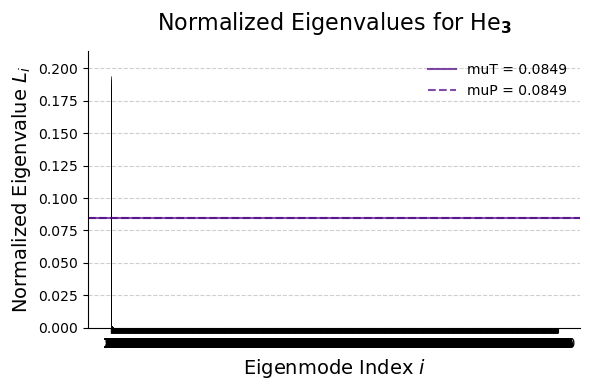

In [107]:
import torch
import matplotlib.pyplot as plt
import time
from math import pi

# Define global experimental parameters (use P=300 for Eigh feasibility)


class ExperimentMF:
    def __init__(self, d):
        self.d = d
        self.P = 8_000  # Reduced P for full Eigh decomposition


experimentMF = ExperimentMF(d=5)
P = experimentMF.P
d = experimentMF.d
device = 'cpu'  # Use CPU for Eigh on a large matrix

# Set theoretical target for linear mode (l=1)
# Assuming T_factor = 4 / (3 * pi) for linear modes, and scaled by 1/d
T_factor = 4 / (3 * pi)
# Expected single linear eigenvalue (approx 0.08488)
THEORY_LAMBDA_LINEAR = T_factor / d

# Dummy values for horizontal lines (replace with your actual muT, muP)
muT = THEORY_LAMBDA_LINEAR
muP = THEORY_LAMBDA_LINEAR
# -------------------------------------------------
# 1. Data (Input variance is 1, E[||x||^2] = d)
# -------------------------------------------------
X = torch.randn(P, d, device=device)

# -------------------------------------------------
# 2. Corrected Kernel Matrix Calculation
# (Accounts for Sigma_w = I_d/d by scaling inner products by 1/d)
# -------------------------------------------------

print(f"Calculating {P}x{P} kernel matrix...")

# Unscaled inner product (P x P)
inner_unscaled = X @ X.T

# Scaled inner product: 1/d * x_i^T x_j
inner_scaled = inner_unscaled / d

# Scaled norms: 1/d * x_i^T x_i (P x 1)
norm_sq = torch.sum(X**2, dim=1)
norm_sq_scaled = norm_sq / d

# Denominator construction
denom = 1 + 2 * norm_sq_scaled
sqrt_denom_outer = torch.sqrt(denom[:, None]) * torch.sqrt(denom[None, :])

# Argument of arcsin
arg = 2 * inner_scaled / sqrt_denom_outer

# Final Kernel Matrix
K_full = (2 / torch.pi) * torch.arcsin(arg)

# -------------------------------------------------
# 3. Eigendecomposition and Correction
# -------------------------------------------------
print(f"Starting Eigh decomposition for K_full ({P}x{P})...")
t0 = time.time()
S_full, U_full = torch.linalg.eigh(K_full)
elapsed = time.time() - t0
print(f"Eigh done in {elapsed:.2f}s")


# --- CRITICAL FIX FOR BATCHED EIGH OUTPUT ---
# If S_full is returned as a matrix (e.g., d x P), reduce it to a 1D vector (P,).
# We assume the unique set of eigenvalues is contained in the last dimension.
if S_full.dim() > 1 and S_full.shape[0] != S_full.shape[1]:
    # Select the first row/batch index, assuming it contains the P unique eigenvalues
    S_full_vector = S_full[0, :]
else:
    S_full_vector = S_full

# Eigenvalues are returned in ascending order. Reverse to get largest first.
S_descending = S_full_vector.flip(dims=[0])

# Select the linear modes (top d=5)
d_modes = P
linear_eigenvalues_emp = S_descending[:d_modes]

# Calculate the full normalized eigenvalues (L_i)
# Note: S_descending contains the unnormalized eigenvalues (lambda_i)
L = S_descending / torch.sum(S_descending)
learnabilities = L  # Using L as the approximation for high capacity modes

# For plotting, clip the top 30 eigenvalues for better visualization
plot_D = P
plot_learnabilities = learnabilities[:plot_D].cpu().numpy()

# -------------------------------------------------
# 4. Analysis and Verification
# -------------------------------------------------

print("\n--- Verification ---")

# Empirical Average Linear Eigenvalue
emp_avg_lambda_linear = torch.mean(linear_eigenvalues_emp).item()

print(f"Theoretical Lambda_linear (Target): {THEORY_LAMBDA_LINEAR:.5f}")
print(
    f"Empirical Average Lambda_linear (Top {d}): {emp_avg_lambda_linear:.5f}")

ratio = emp_avg_lambda_linear / THEORY_LAMBDA_LINEAR
print(f"Ratio (Empirical / Theoretical): {ratio:.4f}")

# C. Print the specific top 5 eigenvalues (using explicit formatting)
print(f"\nTop {d} Unnormalized Empirical Eigenvalues:")
eigs_list = linear_eigenvalues_emp.tolist()
output_string = "["
for i, l in enumerate(eigs_list):
    output_string += "{:.5f}".format(l)
    if i < len(eigs_list) - 1:
        output_string += ", "
output_string += "]"
print(output_string)


# -------------------------------------------------
# 5. Plotting (Using non-LaTeX safe formatting)
# -------------------------------------------------

# Ensure LaTeX processing is OFF
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "mathtext.fontset": "dejavusans"
})

COLOR_HIGHLIGHT = '#E3735E'
COLOR_NORMAL = '#3F7290'
COLOR_MU = '#4B0082'

# Create the color array for the top D_plot modes
colors = [COLOR_HIGHLIGHT] + [COLOR_NORMAL] * (plot_D - 1)
indices = np.arange(1, plot_D + 1)

fig, ax = plt.subplots(figsize=(6, 4))

# Generate the bar plot
ax.bar(indices, plot_learnabilities, color=colors,
       width=0.8, edgecolor='black', linewidth=0.5)

# --- ADD HORIZONTAL REFERENCE LINES ---
ax.axhline(muT, color=COLOR_MU, linestyle='-', linewidth=1.5,
           label=f'muT = {muT:.4f}', alpha=0.7)
ax.axhline(muP, color=COLOR_MU, linestyle='--',
           linewidth=1.5, label=f'muP = {muP:.4f}', alpha=0.7)


# 4. Formatting and Labels (Plain text / Mathtext where safe)

# Title (using Mathtext where safe, otherwise plain text)
ax.set_title(
    r'$\mathbf{\mathrm{Normalized \ Eigenvalues \ for \ He}_{3}}$', fontsize=16, pad=15)

# X-axis Label
ax.set_xlabel('Eigenmode Index $i$', fontsize=14)
# Set ticks
if plot_D > 10:
    ax.set_xticks([1] + list(range(5, plot_D + 1, 5)))
else:
    ax.set_xticks(indices)

# Y-axis Label
ax.set_ylabel('Normalized Eigenvalue $L_i$', fontsize=14)
ax.set_ylim(0, max(plot_learnabilities) * 1.1)

# Add grid lines
ax.grid(axis='y', linestyle='--', alpha=0.6)

# Remove top and right spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Add Legend
ax.legend(loc='upper right', frameon=False, fontsize=10)

plt.tight_layout()
plt.show()

In [108]:
learnabilities[:10]

tensor([0.1941, 0.1919, 0.1879, 0.1844, 0.1835, 0.0018, 0.0018, 0.0018, 0.0018,
        0.0017])